### Introduction to Lab 5

Great job in making it to this point in the course! You will work on Lab 5 next.

You have already created the AddDragon and ValidateDragon AWS Lambda functions. In this lab, you will complete the POST method of your application programming interface (API). You will also build a workflow for the Lambda functions by creating an AWS Step Functions state machine.

Again, if you have questions about the lab, it’s likely that you’re not alone. Use the discussion forum to post questions to your peers in the course, and we also encourage you to answer other learners’ questions. Have fun! 

<pre>


    
</pre>
### Exercise 5: AWS Step Functions

https://aws-tc-largeobjects.s3.amazonaws.com/DEV-AWS-MO-BuildingRedux/exercise-5-stepfunctions.html

<b>Note</b>
The exercises in this course will have an associated charge in your AWS account. In this exercise, you will create the following resource:

    * AWS Step Functions state machine with Standard Workflow
    
<b>The final exercise includes instructions to delete all the resources that you create in the exercises.</b>

Familiarize yourself with AWS Step Functions pricing (https://aws.amazon.com/step-functions/pricing/) and the AWS Free Tier (https://aws.amazon.com/free/).

<pre>


    
</pre>
### Exercise 5: AWS Step Functions

In this exercise, you complete the POST method of your application programming interface (API). You have already created the AddDragon and ValidateDragon AWS Lambda functions. You create an AWS Step Functions state machine to build a workflow for the Lambda functions.

### Task 1: Finding AWS Lambda ARNs

In this task, you will find the Amazon Resource Names (ARNs) for the `AddDragon` and `ValidateDragon` AWS Lambda functions. ARNs are used to uniquely identify resources. They are used across all of AWS when you specify a resource, such as in an AWS Identity and Access Management (IAM) policy. For more information, see Amazon Resource Names (https://docs.aws.amazon.com/general/latest/gr/aws-arns-and-namespaces.html) in the AWS General Reference guide.

1. In the AWS Cloud9 or local IDE terminal, list the ARNs by using the following AWS Command Line Interface (AWS CLI) command. The --query parameter uses JMESPath syntax to filter the output to include only the ARNs.

    `aws lambda list-functions --query 'Functions[].FunctionArn'`

2. Note the ARNs of the AddDragon and ValidateDragon functions. They will look similar to this example: arn:aws:lambda:us-east-1:123456789012:function:AddDragon

### Task 2: Creating the Step Functions workflow

In this task, you will orchestrate `AddDragon` and `ValidateDragon` by creating a Step Functions state machine with a standard workflow.

1. In the console, choose Services, and search for and open Step Functions.

2. Make sure that you are in the N. Virginia Region (us-east-1).

3. If you don’t have any existing state machines, you will see a Get Started screen. You can ignore this option and choose the ☰ menu icon (in the top-left area of the window), and then choose State machines.

4. Choose `Create state machine`.

5. Select Write your workflow in code.

6. Scroll down to the Definition section. You should see a sample workflow in Amazon States Language.

7. Replace the sample workflow with the following JavaScript Object Notation (JSON) code. Update both the *REPLACE_WITH_ValidateDragon_ARN* and *REPLACE_WITH_AddDragon_ARN* placeholders with the ARNs that you retrieved in the previous section.
```bash
{
  "Comment": "Dragon will be validated. If validation fails, a failure message will be sent. If the dragon is valid, it will be added to the data and a success message will be sent.",
  "StartAt": "ValidateDragon",
  "States": {
    "ValidateDragon": {
      "Type": "Task",
      "Resource": "<REPLACE_WITH_ValidateDragon_ARN>",
      "Catch": [
        {
          "ErrorEquals": [
            "DragonValidationException"
          ],
          "Next": "AlertDragonValidationFailure",
          "ResultPath": null
        },
        {
          "ErrorEquals": [
            "States.ALL"
          ],
          "Next": "CatchAllFailure"
        }
      ],
      "Next": "AddDragon",
      "ResultPath": null
    },
    "AlertDragonValidationFailure": {
      "Type": "Task",
      "Resource": "arn:aws:states:::sns:publish",
      "Parameters": {
        "Message": "The dragon you reported failed validation and was not added.",
        "PhoneNumber.$": "$.reportingPhoneNumber"
      },
      "End": true
    },
    "CatchAllFailure": {
      "Type": "Fail",
      "Cause": "Something unknown went wrong."
    },
    "AddDragon": {
      "Type": "Task",
      "Resource": "<REPLACE_WITH_AddDragon_ARN>",
      "Next": "ConfirmationRequired",
      "ResultPath": null
    },
    "ConfirmationRequired": {
      "Type": "Choice",
      "Choices": [
        {
          "Variable": "$.confirmationRequired",
          "BooleanEquals": true,
          "Next": "AlertAddDragonSuccess"
        },
        {
          "Variable": "$.confirmationRequired",
          "BooleanEquals": false,
          "Next": "NoAlertAddDragonSuccess"
        }
      ],
      "Default": "CatchAllFailure"
    },
    "AlertAddDragonSuccess": {
      "Type": "Task",
      "Resource": "arn:aws:states:::sns:publish",
      "Parameters": {
        "Message": "The dragon you reported has been added!",
        "PhoneNumber.$": "$.reportingPhoneNumber"
      },
      "End": true
    },
    "NoAlertAddDragonSuccess": {
      "Type": "Succeed"
    }
  }
}
```

On the right, a diagram of your workflow steps appears.  
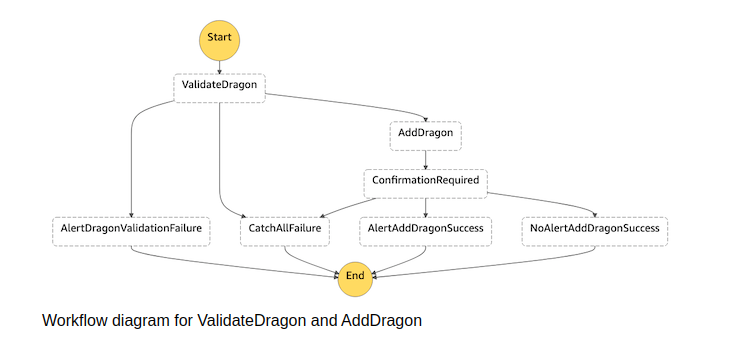
  
**Note**: If you see an error message, reload the page and repeat the instructions in this task.

8. Choose Next.

9. For State machine name, enter `DragonsStateMachine`.

10. For Permissions, keep the default setting of Create new role.

    The Step Functions console will create an AWS Identity and Access Management (IAM) role for you that allows publishing for AWS X-Ray and Amazon Simple Notification Service (Amazon SNS). The role also allows invoking Lambda for the two functions.

11. Under Tracing, select Enable X-Ray tracing because you will look at that feature in the next exercise.

12. Choose *Create state machine*.

13. Note the ARN of the new state machine. It will look similar to this example: arn:aws:states:us-east-1:123456789012:stateMachine:DragonsStateMachine

### Task 3: Creating a policy and a role in IAM

In this task, you will create a policy called dragons-apig-policy, which you will attach to an API Gateway role called dragons-apig-role. This policy and role allow API Gateway to run the `StartExecution action` for the state machine workflow. The dragons-apig-policy is defined through the following JSON code.
```bash
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": "states:StartExecution",
            "Resource": "*"
        }
    ]
}
```
If you are familiar with IAM policies and roles, you might want to try completing this section before you use the step-by-step instructions.

>> Expand for step-by-step instructions.

### Task 4: Updating the POST method of the REST API

In this task, you will update the POST method of the REST API so that it starts the execution of a Step Functions workflow. First, you will remove the mock integration that you are currently using in the POST method. You will then connect the method to the state machine workflow for the Lambda functions.

1. In the console, open the Amazon API Gateway dashboard.

2. Choose the DragonsApp REST API.

3. In the Resources navigation pane, select the POST method of the `/dragons` resource.

4. Choose Integration Request and configure the following settings.
    * Integration type: AWS Service
    * AWS Region: us-east-1
    * AWS Service: Step Functions
    * HTTP method: POST
    * Action Type: Use action name
    * Action: StartExecution
    * Execution role: Enter the ARN for dragons-apig-role that you noted
      
5. Choose Save.

6. When you are prompted with Are you sure you want to switch to a AWS integration?, choose OK.

### Task 5: Configuring the mapping template

In this task, you will set up a mapping template for the POST method of the REST API. The mapping template converts the POST body that the application sends into a body that the Step Functions StartExecution (https://docs.aws.amazon.com/step-functions/latest/apireference/API_StartExecution.html) method understands.

This means updating the property names (such as changing dragonName to dragon_name_str), and including the state machine ARN as a parameter. The input parameter for StartExecution must be escaped so that it can be used in JSON. For more information, see $util Variables (https://docs.aws.amazon.com/apigateway/latest/developerguide/api-gateway-mapping-template-reference.html#util-template-reference) in the Amazon API Gateway Developer Guide.

1. In the /dragons - POST - Integration Request page, scroll down and expand the Mapping Templates section.

2. For Request body passthrough, select When there are no templates defined.

3. Choose Add mapping template.

4. Under Content-Type, enter application/json and save the setting by choosing the check (create) icon.

5. Scroll down to the template text box and paste the following Apache Velocity Template Language (VTL) template. Update <REPLACE-WITH-STATE-MACHINE-ARN> with the state machine ARN that you noted previously.
```bash
#set($data = $input.path('$'))

#set($input = " {
  ""dragon_name_str"" : ""$data.dragonName"",
  ""description_str"" : ""$data.description"",
  ""family_str"" : ""$data.family"",
  ""location_city_str"" : ""$data.city"",
  ""location_country_str"" : ""$data.country"",
  ""location_state_str"" : ""$data.state"",
  ""location_neighborhood_str"" : ""$data.neighborhood"",
  ""reportingPhoneNumber"" : ""$data.reportingPhoneNumber"",
  ""confirmationRequired"" : $data.confirmationRequired}")

{
    "input": "$util.escapeJavaScript($input).replaceAll("\\'", "'")",
    "stateMachineArn": "<REPLACE-WITH-STATE-MACHINE-ARN>"
}
```

6. Under the template box, choose Save.

### Task 6: Re-enabling CORS and deploying the API

The changes to the POST method will remove the setting for Cross-Origin Resource Sharing (CORS) that you created previously. You will now follow the same instructions to apply CORS settings to your /dragons resource.

1. In the Resources navigation pane, choose /dragons.

2. Select Actions > Enable CORS.

    You might need to scroll to the top of the window to find the Actions menu.

3. Choose Enable CORS and replace existing CORS headers.

4. Confirm the action by choosing Yes, replace existing values.

5. Select Actions > Deploy API.

6. For Deployment stage, select prod.

7. Choose Deploy.

### Task 7: Testing in the web application

In this task, you will test the updated POST method in the web application. The POST method will start the execution of the Step Functions state machine. You can inspect the results of each execution in the Step Functions console.

1. Visit the URL for your Dragons application. If you don’t have it bookmarked, the URL will be `https://<MY-BUCKET>.s3.amazonaws.com/dragonsapp/index.html`. Make sure to replace *MY-BUCKET* with the unique bucket name that you created.

   The application remembers your Dragons endpoint, Amazon Cognito domain, and Amazon Cognito Client ID. If these resources aren’t available, you can retrieve them from previous exercises.

2. In the web application, choose Login. The login flow will update the Amazon Cognito ID token in your application.

3. After you complete the login process, choose Add.

4. Enter the details for a new dragon, and choose POST /dragons. A successful POST operation will clear the form so that it’s ready to enter another dragon.

5. Now, use the POST method for an existing dragon name, such as Bahamethut.

6. In the console, return to the Step Functions dashboard.

7. Choose DragonsStateMachine. You should see the two state machine executions for the calls to the POST method that were initiated from your web application.

8. View both state machine executions and compare the diagrams for each one. Select the step in each diagram and observe the Details, Step input, and Step output tabs (where available).
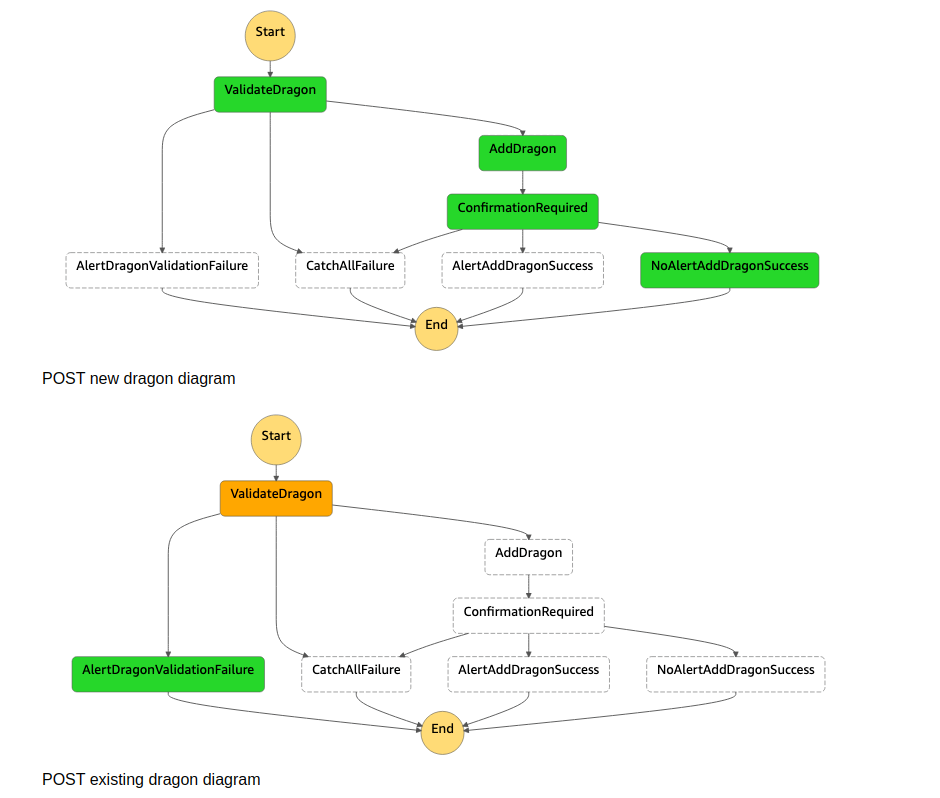
  
9. Return to the web application, choose List, and then choose GET /dragons. You should see the newly added dragon in the results table.